In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
from PIL import Image
import torchvision.transforms as transforms

/home/vamsi/miniconda3/envs/nlp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("osunlp/MagicBrush")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 8807
    })
    dev: Dataset({
        features: ['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'],
        num_rows: 528
    })
})

In [4]:
print(ds['train'][0].keys())

dict_keys(['img_id', 'turn_index', 'source_img', 'mask_img', 'instruction', 'target_img'])


In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Typical ImageNet normalization
])

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [7]:
import io
class MagicBrushDataset(Dataset):
    def __init__(self, split='train', fraction=1.0):
        if fraction<1.0:
            split = f"{split}[:{int(fraction * 100)}%]"
        self.dataset = load_dataset("osunlp/MagicBrush", split=split)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Retrieve the item from the dataset
        item = self.dataset[idx]

        # Process text: encode with BERT tokenizer and get embeddings
        text = item['instruction']
        tokens = tokenizer(text, return_tensors='pt', padding='max_length', max_length=128, truncation=True)
        with torch.no_grad():
            text_embedding = bert_model(**tokens).last_hidden_state[:, 0, :]  # CLS token embedding (768-dimensional)

        if isinstance(item['source_img'], Image.Image):  # Already a PIL image
            image = item['source_img'].convert('RGB')
        else:
            raise ValueError(f"Unexpected type for 'source_img': {type(item['source_img'])}")
        
        # Apply image transformations
        image = image_transform(image)

        # Process binary mask (convert to binary tensor)
        if isinstance(item['mask_img'], Image.Image):  # Check if already a PIL image
            mask = item['mask_img'].convert('L')
        else:
            raise ValueError(f"Unexpected type for 'mask': {type(item['mask'])}")

        mask = transforms.Resize((224, 224))(mask)
        mask = transforms.ToTensor()(mask)
        mask = (mask > 0).float()  # Binary mask
        mask = mask.squeeze(0)
        return text_embedding.squeeze(0), image, mask

In [8]:
train_dataset = MagicBrushDataset(split='train', fraction=0.5)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8, pin_memory=True)

In [9]:
test_dataset = MagicBrushDataset(split='dev')
test_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

In [10]:
print(len(train_dataset), len(test_dataset))

4404 528


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import ResNet50_Weights

resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
for param in resnet.parameters():
    param.requires_grad = False

resnet = nn.Sequential(*list(resnet.children())[:-1])

projection_layer = nn.Linear(2048, 768)

class MaskPredictor(nn.Module):
    def __init__(self, resnet, projection_layer):
        super(MaskPredictor, self).__init__()
        self.resnet = resnet
        self.projection = projection_layer
        self.mask_prediction_network = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [32, 16, 768, 768]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                  # [32, 16, 384, 384]
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # [32, 32, 384, 384]
            nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=1),                  # [32, 32, 192, 192]

            # nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)
            nn.AdaptiveAvgPool2d((224, 224)), # [32, 32, 224, 224]
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1), # [32, 1, 224, 224]
            nn.Sigmoid()
        )

    def forward(self, img, text):
        features = self.resnet(img)
        features = features.view(features.size(0), -1)  
        img_features = self.projection(features)

        # Perform the cross product (outer product) between img and text
        cross_product = torch.bmm(img_features.unsqueeze(2), text.unsqueeze(1))  # Shape: [batch_size, 768, 768]
        cross_product = cross_product.unsqueeze(1)
        # print(2,'-',cross_product.shape)
        out = self.mask_prediction_network(cross_product)  # Shape: [batch_size, 1, 224*224]
        # print(3,'-',out.shape)
        
        return out.squeeze(1)  # Shape: [batch_size, 224, 224]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MaskPredictor(resnet, projection_layer).to(device)
print(device)

cuda


In [12]:
model = torch.load("generic_maskpredictor.pth").to(device)

/tmp/ipykernel_116466/2878499212.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("generic_maskpredictor.pth").to(device)


In [ ]:
from tqdm import tqdm

criterion = nn.BCELoss()  # Combine sigmoid and BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        optimizer.zero_grad()

        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 224, 224]

        loss = criterion(pred_mask, gt_mask)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, "generic_maskpredictor.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

100%|██████████| 138/138 [04:35<00:00,  1.99s/it]


Epoch [1/10], Loss: 0.4370


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [2/10], Loss: 0.4071


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [3/10], Loss: 0.4041


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [4/10], Loss: 0.3998


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [5/10], Loss: 0.3956


100%|██████████| 138/138 [04:01<00:00,  1.75s/it]


Epoch [6/10], Loss: 0.3917


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [7/10], Loss: 0.3861


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [8/10], Loss: 0.3808


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [9/10], Loss: 0.3776


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [10/10], Loss: 0.3704


In [ ]:
from tqdm import tqdm

criterion = nn.BCELoss()  # Combine sigmoid and BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        optimizer.zero_grad()

        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 224, 224]

        loss = criterion(pred_mask, gt_mask)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, "generic_maskpredictor.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [1/100], Loss: 0.3625


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [2/100], Loss: 0.3526


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [3/100], Loss: 0.3445


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [4/100], Loss: 0.3366


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [5/100], Loss: 0.3302


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [6/100], Loss: 0.3240


100%|██████████| 138/138 [04:23<00:00,  1.91s/it]


Epoch [7/100], Loss: 0.3189


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [8/100], Loss: 0.3135


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [9/100], Loss: 0.3107


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [10/100], Loss: 0.3064


100%|██████████| 138/138 [04:04<00:00,  1.77s/it]


Epoch [11/100], Loss: 0.3023


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [12/100], Loss: 0.2991


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [13/100], Loss: 0.2961


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [14/100], Loss: 0.2946


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [15/100], Loss: 0.2915


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [16/100], Loss: 0.2894


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [17/100], Loss: 0.2857


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [18/100], Loss: 0.2865


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [19/100], Loss: 0.2838


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [20/100], Loss: 0.2806


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [21/100], Loss: 0.2796


100%|██████████| 138/138 [04:18<00:00,  1.87s/it]


Epoch [22/100], Loss: 0.2788


100%|██████████| 138/138 [04:17<00:00,  1.86s/it]


Epoch [23/100], Loss: 0.2754


100%|██████████| 138/138 [04:09<00:00,  1.80s/it]


Epoch [24/100], Loss: 0.2754


100%|██████████| 138/138 [04:18<00:00,  1.87s/it]


Epoch [25/100], Loss: 0.2744


100%|██████████| 138/138 [04:20<00:00,  1.88s/it]


Epoch [26/100], Loss: 0.2737


 70%|██████▉   | 96/138 [03:01<00:24,  1.75it/s]

In [15]:
from tqdm import tqdm

criterion = nn.BCELoss()  # Combine sigmoid and BCE loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for text_embedding, img, gt_mask in tqdm(train_loader):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]

        optimizer.zero_grad()

        pred_mask = model(img, text_embedding)  # Output shape: [batch_size, 224, 224]

        loss = criterion(pred_mask, gt_mask)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    torch.save(model, "generic_maskpredictor.pth")
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

100%|██████████| 138/138 [05:12<00:00,  2.27s/it]


Epoch [1/100], Loss: 0.2751


100%|██████████| 138/138 [04:29<00:00,  1.95s/it]


Epoch [2/100], Loss: 0.2712


100%|██████████| 138/138 [04:29<00:00,  1.95s/it]


Epoch [3/100], Loss: 0.2699


100%|██████████| 138/138 [07:53<00:00,  3.43s/it]


Epoch [4/100], Loss: 0.2701


100%|██████████| 138/138 [04:02<00:00,  1.76s/it]


Epoch [5/100], Loss: 0.2684


100%|██████████| 138/138 [04:01<00:00,  1.75s/it]


Epoch [6/100], Loss: 0.2683


100%|██████████| 138/138 [04:02<00:00,  1.76s/it]


Epoch [7/100], Loss: 0.2670


100%|██████████| 138/138 [04:02<00:00,  1.76s/it]


Epoch [8/100], Loss: 0.2657


100%|██████████| 138/138 [04:24<00:00,  1.92s/it]


Epoch [9/100], Loss: 0.2635


100%|██████████| 138/138 [04:28<00:00,  1.95s/it]


Epoch [10/100], Loss: 0.2638


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [11/100], Loss: 0.2637


100%|██████████| 138/138 [04:52<00:00,  2.12s/it]


Epoch [12/100], Loss: 0.2618


100%|██████████| 138/138 [04:13<00:00,  1.83s/it]


Epoch [13/100], Loss: 0.2617


100%|██████████| 138/138 [04:50<00:00,  2.10s/it]


Epoch [14/100], Loss: 0.2628


100%|██████████| 138/138 [05:13<00:00,  2.27s/it]


Epoch [15/100], Loss: 0.2626


100%|██████████| 138/138 [04:04<00:00,  1.77s/it]


Epoch [16/100], Loss: 0.2605


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [17/100], Loss: 0.2599


100%|██████████| 138/138 [04:05<00:00,  1.78s/it]


Epoch [18/100], Loss: 0.2589


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [19/100], Loss: 0.2579


100%|██████████| 138/138 [04:14<00:00,  1.84s/it]


Epoch [20/100], Loss: 0.2580


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [21/100], Loss: 0.2566


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [22/100], Loss: 0.2566


100%|██████████| 138/138 [04:04<00:00,  1.77s/it]


Epoch [23/100], Loss: 0.2564


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [24/100], Loss: 0.2570


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [25/100], Loss: 0.2557


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [26/100], Loss: 0.2558


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [27/100], Loss: 0.2543


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [28/100], Loss: 0.2542


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [29/100], Loss: 0.2537


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [30/100], Loss: 0.2533


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [31/100], Loss: 0.2532


100%|██████████| 138/138 [04:11<00:00,  1.83s/it]


Epoch [32/100], Loss: 0.2527


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [33/100], Loss: 0.2519


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [34/100], Loss: 0.2532


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [35/100], Loss: 0.2519


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [36/100], Loss: 0.2508


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [37/100], Loss: 0.2516


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [38/100], Loss: 0.2506


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [39/100], Loss: 0.2496


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [40/100], Loss: 0.2496


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [41/100], Loss: 0.2498


100%|██████████| 138/138 [04:07<00:00,  1.80s/it]


Epoch [42/100], Loss: 0.2483


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [43/100], Loss: 0.2484


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [44/100], Loss: 0.2481


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [45/100], Loss: 0.2480


100%|██████████| 138/138 [04:18<00:00,  1.87s/it]


Epoch [46/100], Loss: 0.2481


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [47/100], Loss: 0.2480


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [48/100], Loss: 0.2474


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [49/100], Loss: 0.2477


100%|██████████| 138/138 [04:14<00:00,  1.84s/it]


Epoch [50/100], Loss: 0.2459


100%|██████████| 138/138 [04:13<00:00,  1.84s/it]


Epoch [51/100], Loss: 0.2460


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [52/100], Loss: 0.2456


100%|██████████| 138/138 [04:14<00:00,  1.85s/it]


Epoch [53/100], Loss: 0.2458


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [54/100], Loss: 0.2465


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [55/100], Loss: 0.2457


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [56/100], Loss: 0.2453


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [57/100], Loss: 0.2446


100%|██████████| 138/138 [04:11<00:00,  1.82s/it]


Epoch [58/100], Loss: 0.2452


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [59/100], Loss: 0.2451


100%|██████████| 138/138 [04:13<00:00,  1.84s/it]


Epoch [60/100], Loss: 0.2445


100%|██████████| 138/138 [04:13<00:00,  1.83s/it]


Epoch [61/100], Loss: 0.2431


100%|██████████| 138/138 [04:17<00:00,  1.86s/it]


Epoch [62/100], Loss: 0.2440


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [63/100], Loss: 0.2432


100%|██████████| 138/138 [04:13<00:00,  1.83s/it]


Epoch [64/100], Loss: 0.2420


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [65/100], Loss: 0.2425


100%|██████████| 138/138 [04:13<00:00,  1.84s/it]


Epoch [66/100], Loss: 0.2428


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [67/100], Loss: 0.2439


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [68/100], Loss: 0.2427


100%|██████████| 138/138 [04:13<00:00,  1.83s/it]


Epoch [69/100], Loss: 0.2417


100%|██████████| 138/138 [04:13<00:00,  1.84s/it]


Epoch [70/100], Loss: 0.2418


100%|██████████| 138/138 [04:14<00:00,  1.84s/it]


Epoch [71/100], Loss: 0.2414


100%|██████████| 138/138 [04:15<00:00,  1.85s/it]


Epoch [72/100], Loss: 0.2417


100%|██████████| 138/138 [04:12<00:00,  1.83s/it]


Epoch [73/100], Loss: 0.2416


100%|██████████| 138/138 [04:15<00:00,  1.85s/it]


Epoch [74/100], Loss: 0.2421


100%|██████████| 138/138 [04:15<00:00,  1.85s/it]


Epoch [75/100], Loss: 0.2411


100%|██████████| 138/138 [04:14<00:00,  1.84s/it]


Epoch [76/100], Loss: 0.2417


100%|██████████| 138/138 [04:10<00:00,  1.81s/it]


Epoch [77/100], Loss: 0.2407


100%|██████████| 138/138 [04:20<00:00,  1.89s/it]


Epoch [78/100], Loss: 0.2405


100%|██████████| 138/138 [04:25<00:00,  1.92s/it]


Epoch [79/100], Loss: 0.2405


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [80/100], Loss: 0.2406


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [81/100], Loss: 0.2402


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [82/100], Loss: 0.2406


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [83/100], Loss: 0.2405


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [84/100], Loss: 0.2393


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [85/100], Loss: 0.2391


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [86/100], Loss: 0.2392


100%|██████████| 138/138 [04:10<00:00,  1.82s/it]


Epoch [87/100], Loss: 0.2397


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [88/100], Loss: 0.2383


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [89/100], Loss: 0.2381


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [90/100], Loss: 0.2397


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [91/100], Loss: 0.2392


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [92/100], Loss: 0.2387


100%|██████████| 138/138 [04:07<00:00,  1.79s/it]


Epoch [93/100], Loss: 0.2387


100%|██████████| 138/138 [04:09<00:00,  1.80s/it]


Epoch [94/100], Loss: 0.2394


100%|██████████| 138/138 [04:06<00:00,  1.79s/it]


Epoch [95/100], Loss: 0.2395


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [96/100], Loss: 0.2381


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [97/100], Loss: 0.2381


100%|██████████| 138/138 [04:06<00:00,  1.78s/it]


Epoch [98/100], Loss: 0.2380


100%|██████████| 138/138 [04:09<00:00,  1.81s/it]


Epoch [99/100], Loss: 0.2377


100%|██████████| 138/138 [04:08<00:00,  1.80s/it]


Epoch [100/100], Loss: 0.2371


/tmp/ipykernel_418725/3856537233.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("generic_maskpredictor.pth")
  0%|          | 0/138 [00:00<?, ?it/s]C

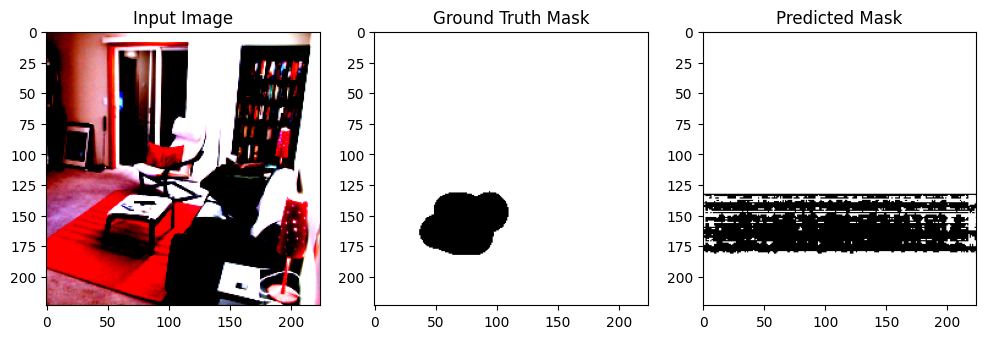

  1%|          | 1/138 [00:12<28:32, 12.50s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


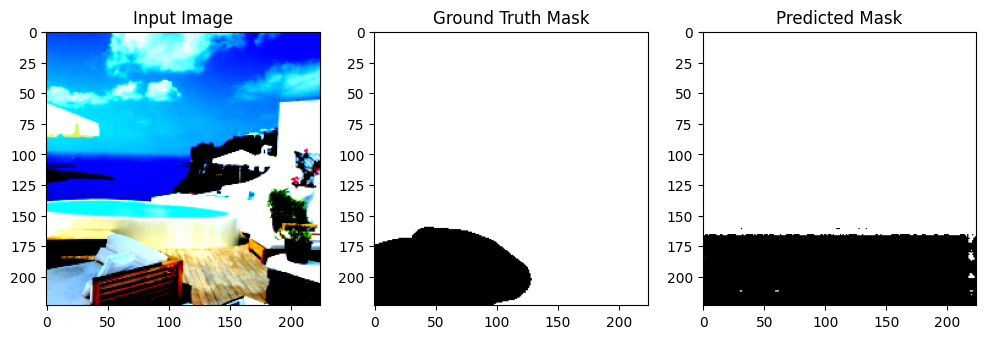

  1%|▏         | 2/138 [00:13<12:20,  5.44s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


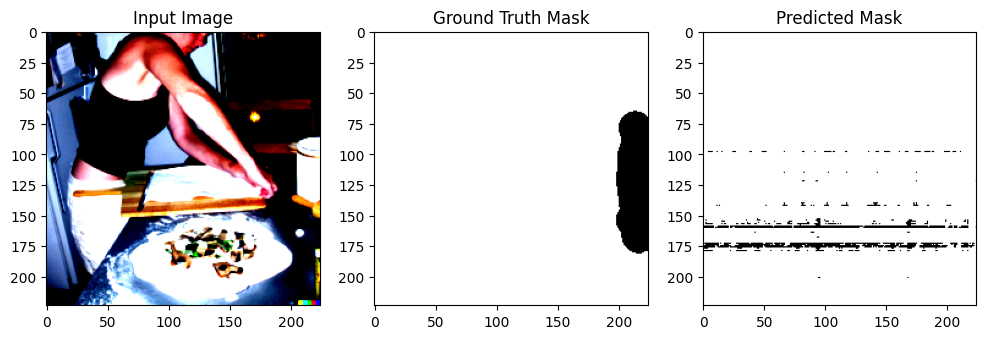

  2%|▏         | 3/138 [00:13<07:03,  3.14s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


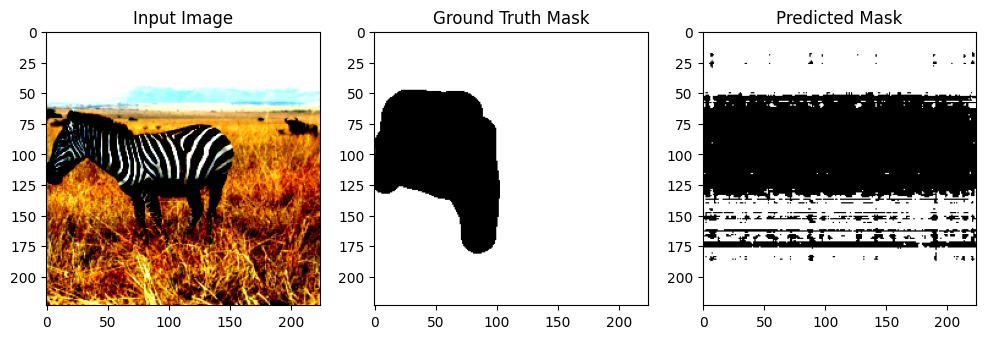

  3%|▎         | 4/138 [00:13<04:34,  2.05s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..2.64].


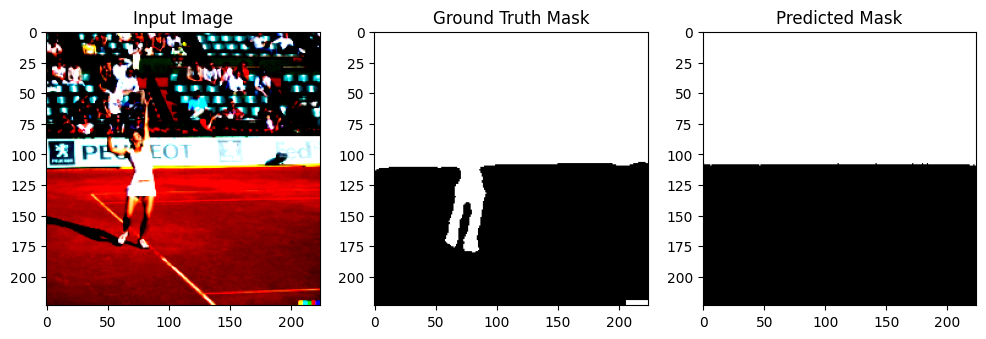

  4%|▎         | 5/138 [00:15<03:55,  1.77s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


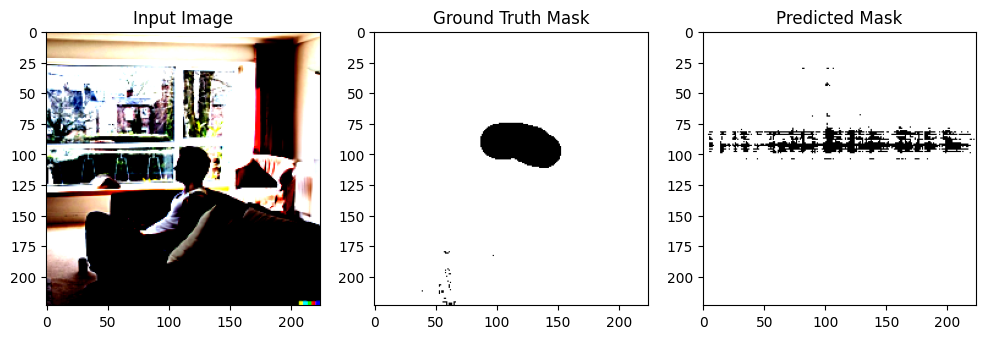

  4%|▍         | 6/138 [00:15<02:54,  1.32s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.64].


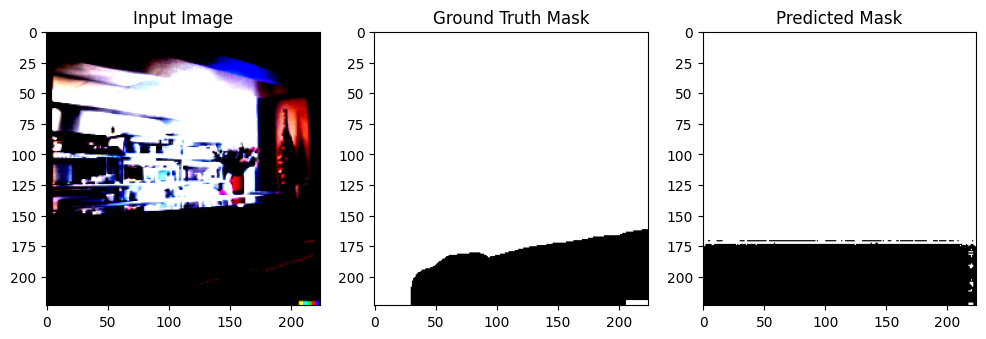

  5%|▌         | 7/138 [00:15<02:12,  1.01s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6384109..2.64].


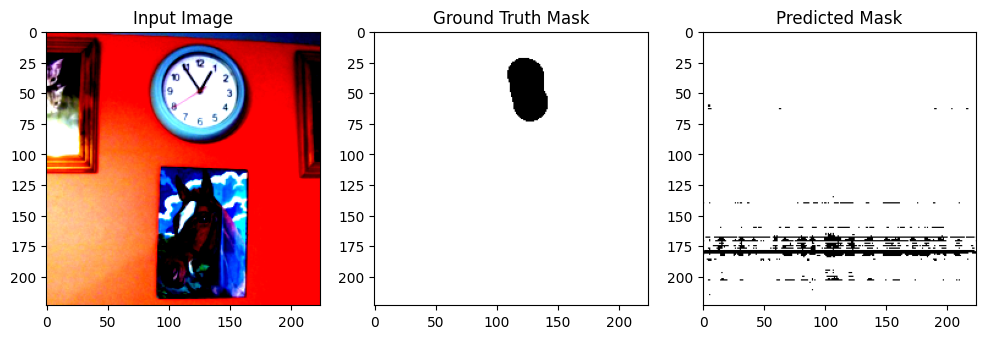

  6%|▌         | 8/138 [00:16<01:46,  1.23it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


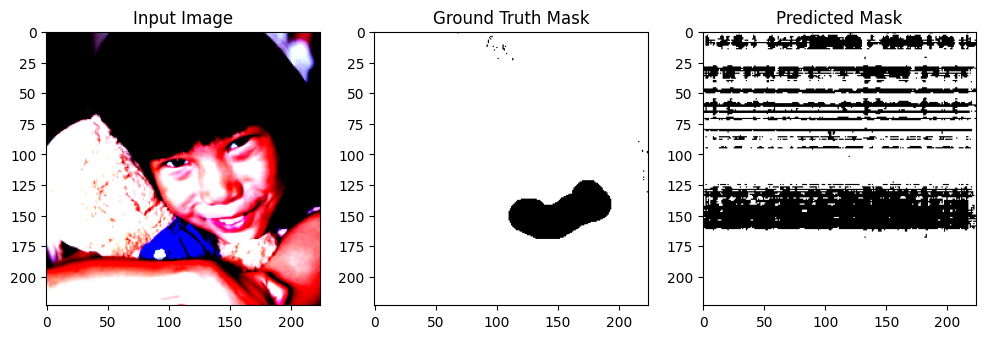

  7%|▋         | 9/138 [00:24<06:42,  3.12s/it]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


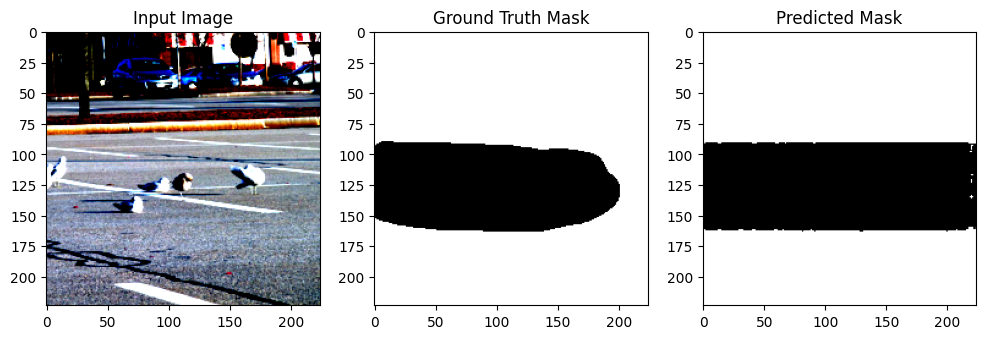

  7%|▋         | 10/138 [00:37<08:04,  3.78s/it]


In [17]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("generic_maskpredictor.pth")
model.eval() 

with torch.no_grad(): 
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device) 
        img = img.to(device) 
        gt_mask = gt_mask.to(device) 

        pred_mask = model(img, text_embedding) 
        # pred_mask = torch.sigmoid(pred_mask) 
        pred_mask = (pred_mask > 0.8).float()
        
        img = img.cpu()
        gt_mask = gt_mask.cpu()
        pred_mask = pred_mask.cpu()

        # Display a few predictions
        if i < 10:  # Display first 3 samples
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(img[0].permute(1, 2, 0))  # Show original image
            axes[0].set_title("Input Image")
            axes[1].imshow(gt_mask[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[1].set_title("Ground Truth Mask")
            axes[2].imshow(pred_mask[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[2].set_title("Predicted Mask")
            plt.show()
        # print(text_embedding)
        if i==10:
            break


/tmp/ipykernel_116466/2788438879.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("/home/vamsi/nlp/crossproduct/generic_maskpredictor.pth")
  0%|      

tensor(0.0350, device='cuda:0')


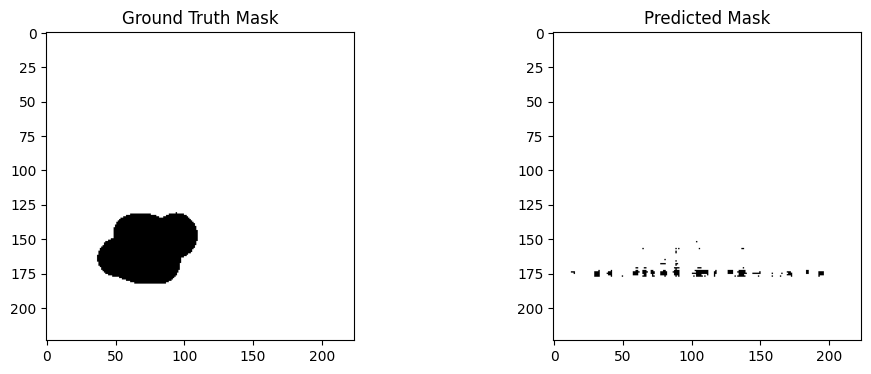

  1%|          | 1/138 [00:16<37:15, 16.31s/it]

tensor(0.3795, device='cuda:0')


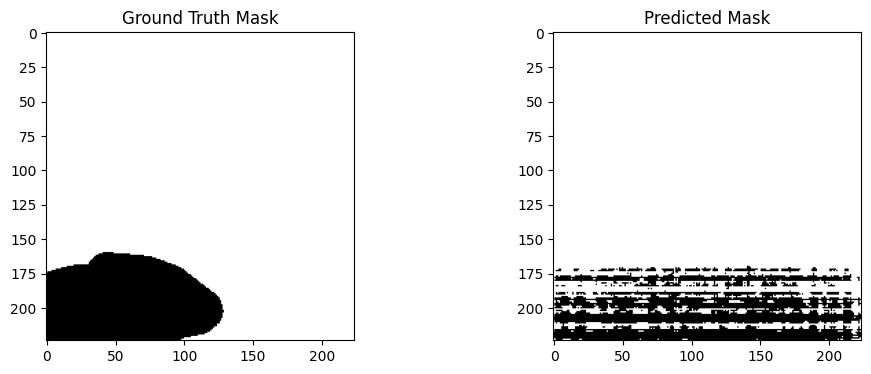

  1%|▏         | 2/138 [00:16<15:46,  6.96s/it]

tensor(0., device='cuda:0')


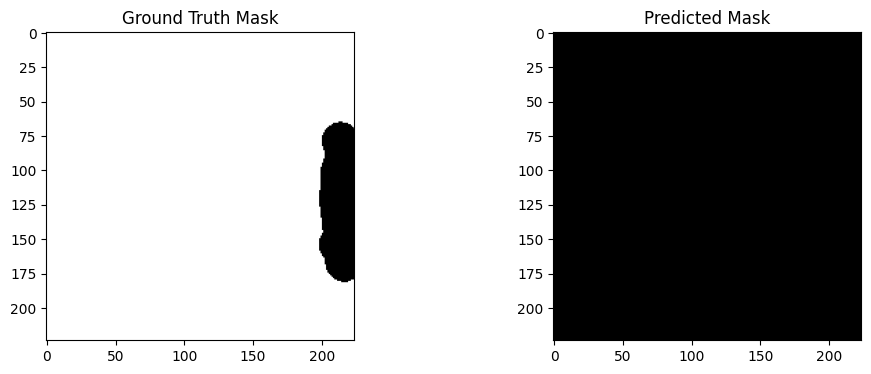

  2%|▏         | 3/138 [00:17<08:54,  3.96s/it]

tensor(0.1408, device='cuda:0')


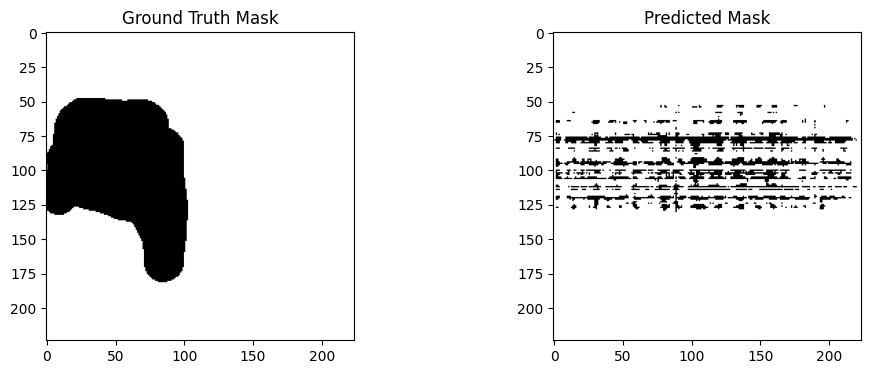

  3%|▎         | 4/138 [00:17<05:43,  2.57s/it]

tensor(0.9268, device='cuda:0')


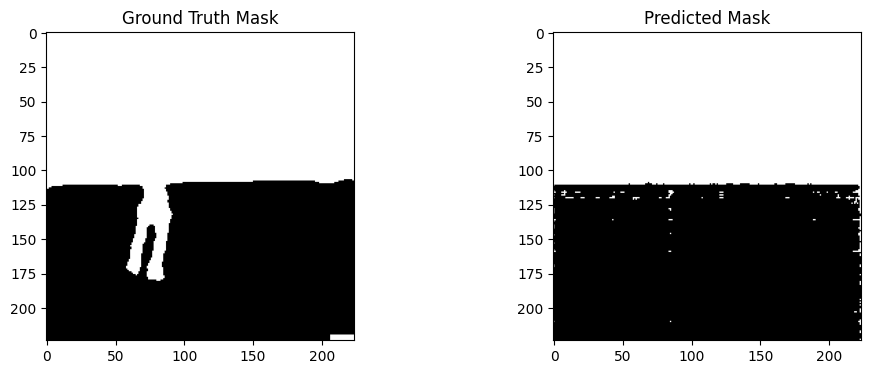

  4%|▎         | 5/138 [00:18<04:00,  1.81s/it]

tensor(0., device='cuda:0')


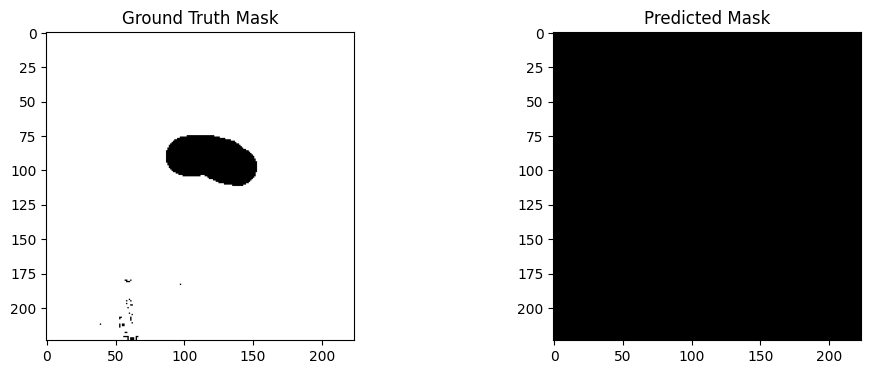

  4%|▍         | 6/138 [00:18<02:54,  1.32s/it]

tensor(0.7117, device='cuda:0')


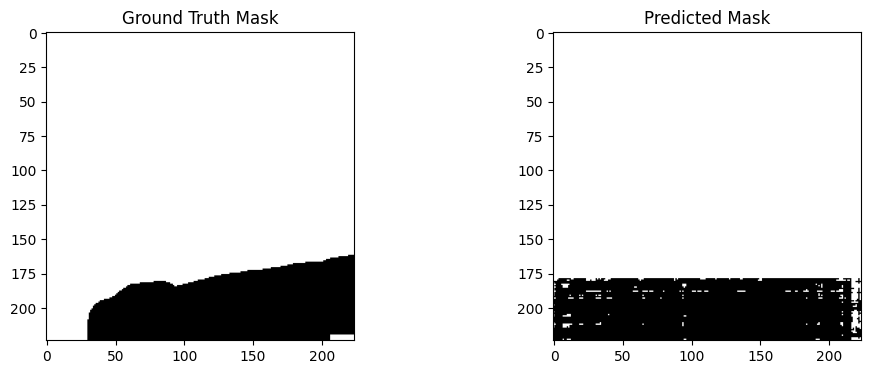

  5%|▌         | 7/138 [00:18<02:12,  1.01s/it]

tensor(0., device='cuda:0')


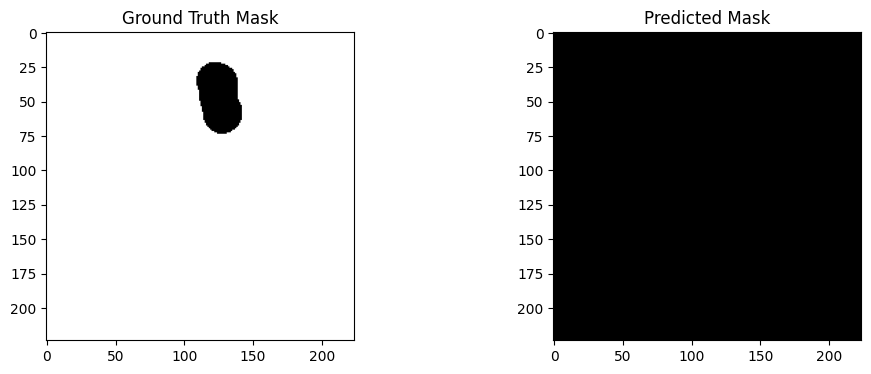

  6%|▌         | 8/138 [00:19<01:43,  1.25it/s]

tensor(0.0023, device='cuda:0')


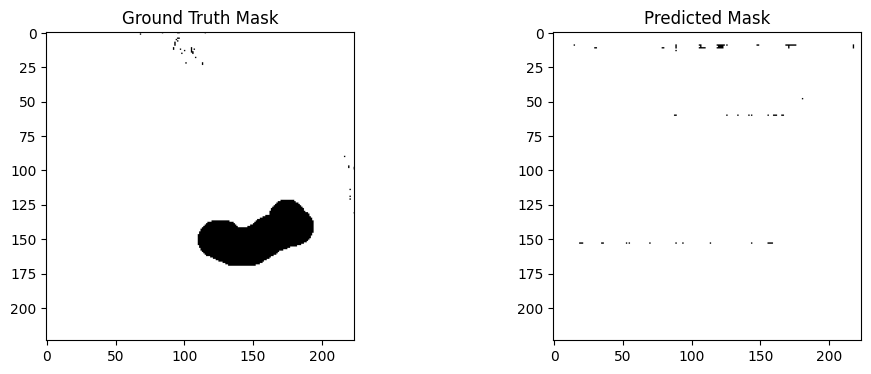

  7%|▋         | 9/138 [00:30<08:48,  4.10s/it]

tensor(0.8088, device='cuda:0')


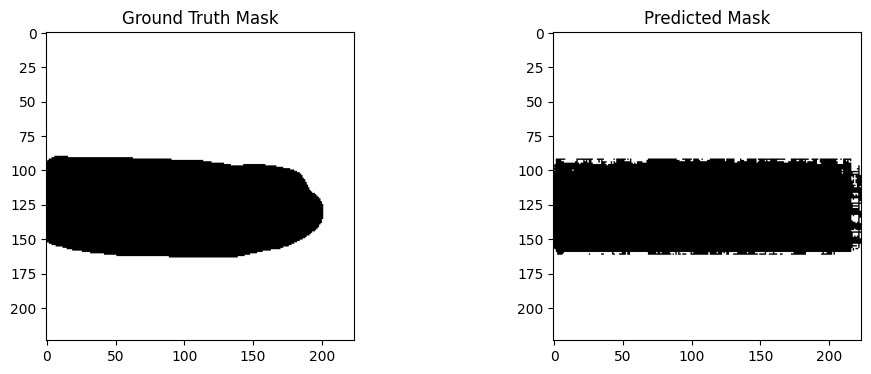

  7%|▋         | 10/138 [00:30<06:17,  2.95s/it]

tensor(0., device='cuda:0')


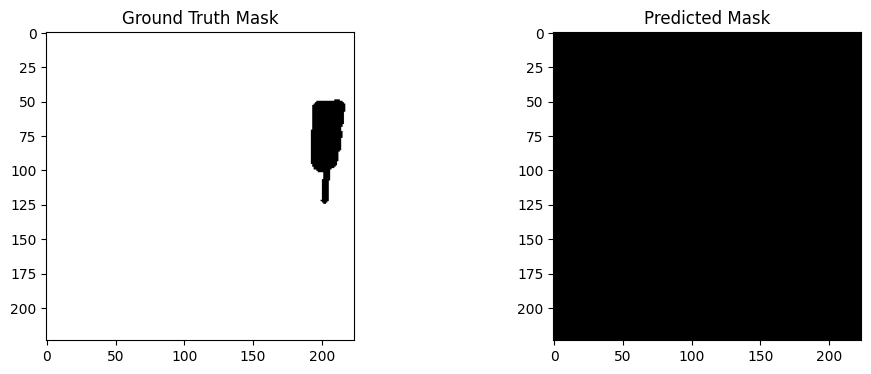

  8%|▊         | 11/138 [00:32<05:21,  2.53s/it]

tensor(0.0030, device='cuda:0')


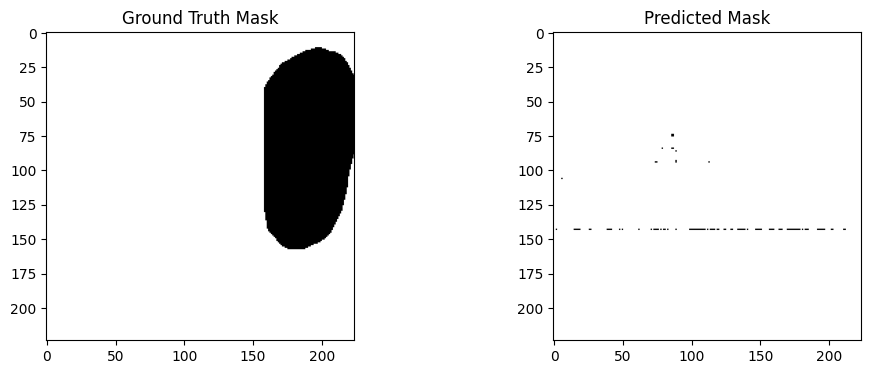

  9%|▊         | 12/138 [00:32<03:56,  1.88s/it]

tensor(0.4694, device='cuda:0')


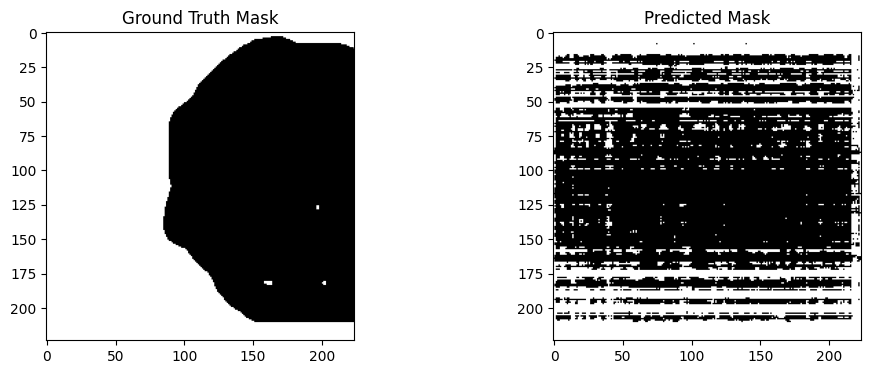

  9%|▉         | 13/138 [00:33<02:56,  1.41s/it]

tensor(0.0070, device='cuda:0')


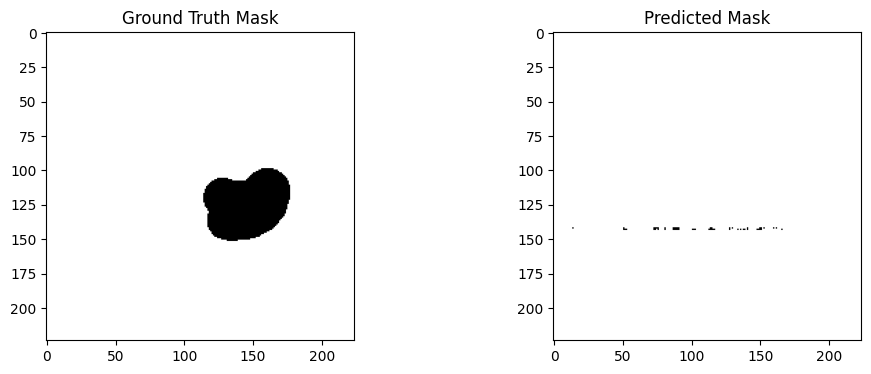

 10%|█         | 14/138 [00:33<02:15,  1.10s/it]

tensor(0.1978, device='cuda:0')


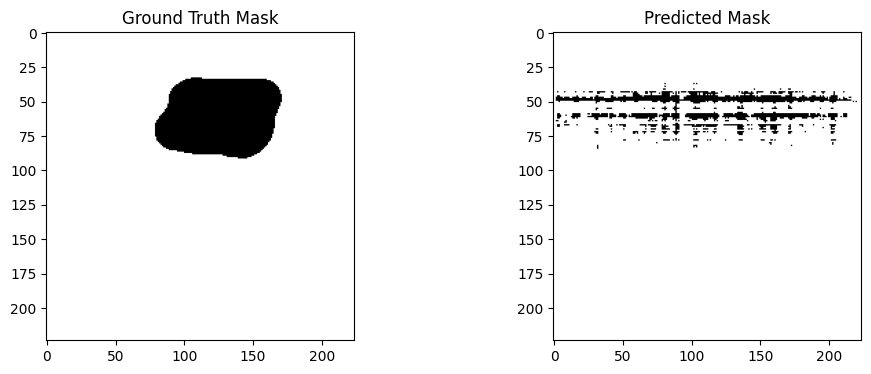

 11%|█         | 15/138 [00:33<01:46,  1.15it/s]

tensor(0.0137, device='cuda:0')


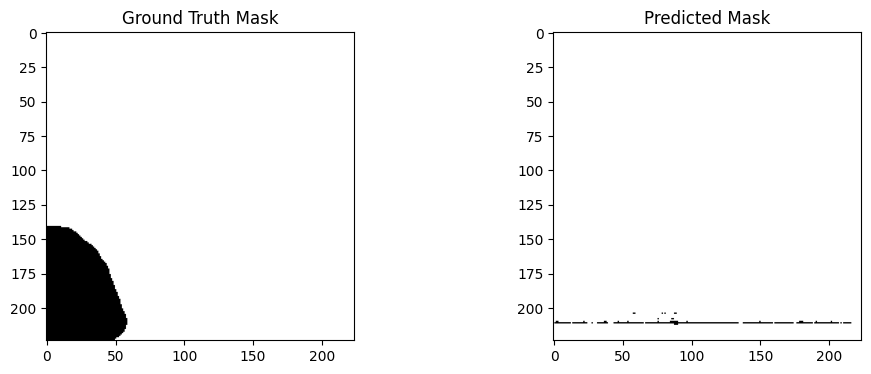

 12%|█▏        | 16/138 [00:34<01:26,  1.41it/s]

tensor(0.0157, device='cuda:0')


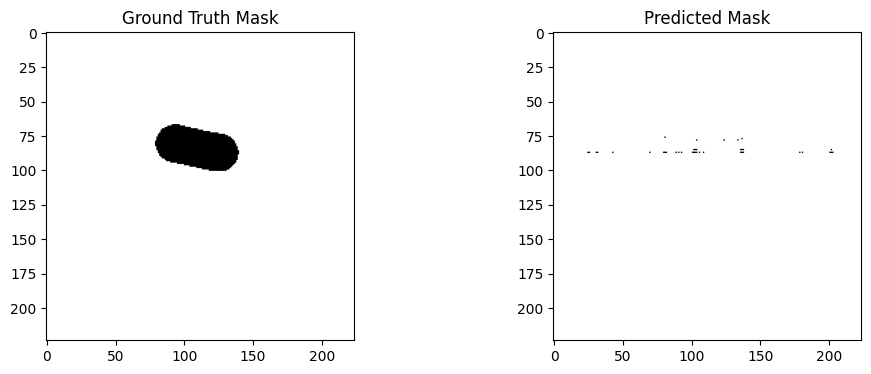

 12%|█▏        | 17/138 [00:46<08:38,  4.29s/it]

tensor(0.0414, device='cuda:0')


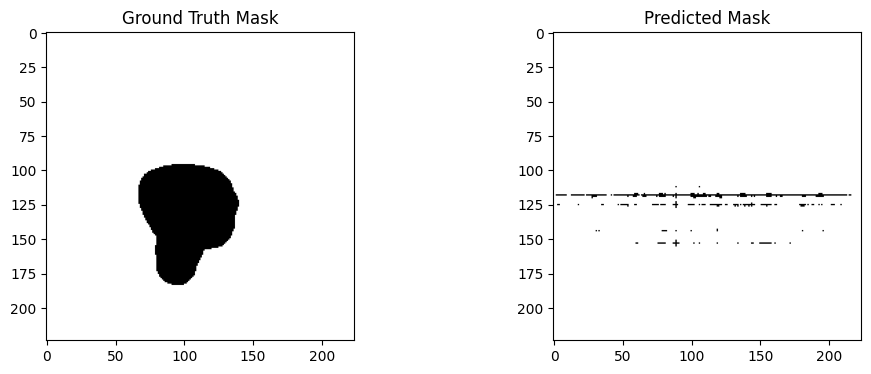

 13%|█▎        | 18/138 [00:47<06:15,  3.13s/it]

tensor(0., device='cuda:0')


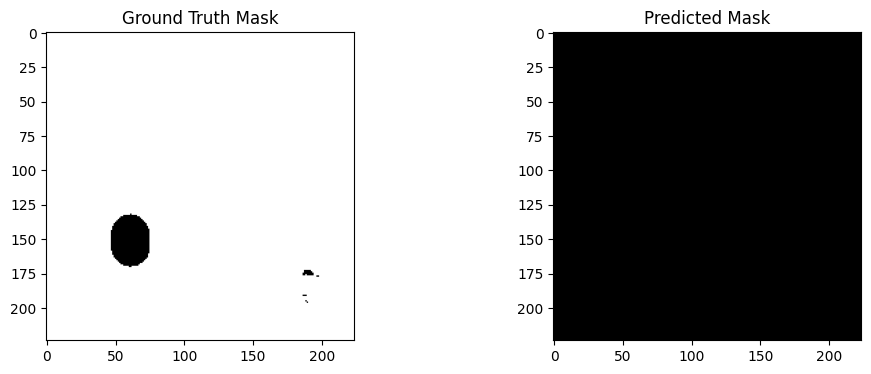

 14%|█▍        | 19/138 [00:47<04:34,  2.30s/it]

tensor(0.1331, device='cuda:0')


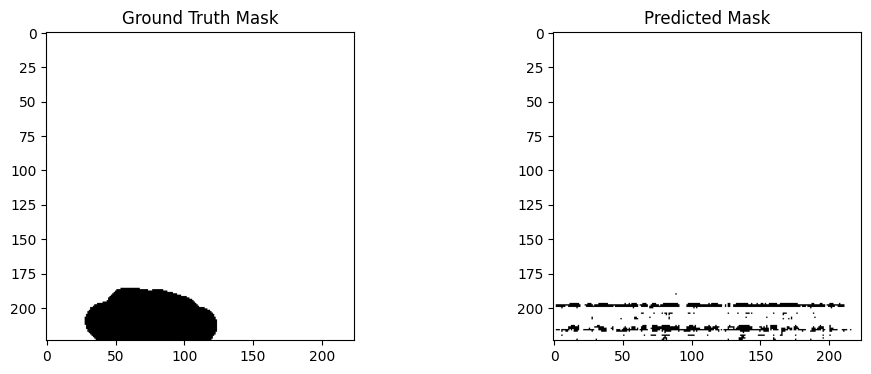

 16%|█▌        | 22/138 [00:48<01:44,  1.11it/s]

tensor(0.6715, device='cuda:0')
tensor(0.0257, device='cuda:0')


 17%|█▋        | 24/138 [00:48<00:57,  2.00it/s]

tensor(0., device='cuda:0')
tensor(0.0011, device='cuda:0')


 18%|█▊        | 25/138 [01:02<08:20,  4.43s/it]

tensor(0.6551, device='cuda:0')


 20%|█▉        | 27/138 [01:02<04:16,  2.31s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 21%|██        | 29/138 [01:02<02:09,  1.19s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 22%|██▏       | 31/138 [01:03<01:08,  1.56it/s]

tensor(0.1333, device='cuda:0')
tensor(0., device='cuda:0')


 23%|██▎       | 32/138 [01:03<00:51,  2.06it/s]

tensor(0.0003, device='cuda:0')


 24%|██▍       | 33/138 [01:16<07:37,  4.35s/it]

tensor(0.0050, device='cuda:0')


 25%|██▌       | 35/138 [01:17<03:55,  2.29s/it]

tensor(0.0711, device='cuda:0')
tensor(0., device='cuda:0')


 27%|██▋       | 37/138 [01:17<01:59,  1.18s/it]

tensor(0.3517, device='cuda:0')
tensor(0.1795, device='cuda:0')


 28%|██▊       | 39/138 [01:17<01:03,  1.57it/s]

tensor(0.0056, device='cuda:0')
tensor(0.8050, device='cuda:0')


 29%|██▉       | 40/138 [01:17<00:47,  2.08it/s]

tensor(0.4960, device='cuda:0')


 30%|██▉       | 41/138 [01:30<06:55,  4.28s/it]

tensor(0.2487, device='cuda:0')


 31%|███       | 43/138 [01:31<03:34,  2.25s/it]

tensor(0.1703, device='cuda:0')
tensor(0., device='cuda:0')


 33%|███▎      | 45/138 [01:31<01:48,  1.16s/it]

tensor(0.0767, device='cuda:0')
tensor(0., device='cuda:0')


 34%|███▍      | 47/138 [01:32<00:57,  1.59it/s]

tensor(0.2683, device='cuda:0')
tensor(0., device='cuda:0')


 35%|███▍      | 48/138 [01:32<00:42,  2.11it/s]

tensor(0.0575, device='cuda:0')


 36%|███▌      | 49/138 [01:45<06:25,  4.33s/it]

tensor(0.0157, device='cuda:0')


 37%|███▋      | 51/138 [01:46<03:21,  2.32s/it]

tensor(0., device='cuda:0')
tensor(0.1884, device='cuda:0')


 38%|███▊      | 53/138 [01:46<01:44,  1.23s/it]

tensor(0.5448, device='cuda:0')
tensor(0.8156, device='cuda:0')


 40%|███▉      | 55/138 [01:47<00:55,  1.51it/s]

tensor(0.0491, device='cuda:0')
tensor(0.5400, device='cuda:0')


 41%|████      | 56/138 [01:47<00:41,  1.99it/s]

tensor(0.9462, device='cuda:0')


 41%|████▏     | 57/138 [02:00<06:02,  4.48s/it]

tensor(0.7414, device='cuda:0')


 43%|████▎     | 59/138 [02:02<03:12,  2.44s/it]

tensor(0.0207, device='cuda:0')
tensor(0.0796, device='cuda:0')


 44%|████▍     | 61/138 [02:02<01:36,  1.25s/it]

tensor(0.7053, device='cuda:0')
tensor(0.2881, device='cuda:0')


 46%|████▌     | 63/138 [02:02<00:50,  1.48it/s]

tensor(0.0015, device='cuda:0')
tensor(0., device='cuda:0')


 46%|████▋     | 64/138 [02:02<00:37,  1.98it/s]

tensor(0.2492, device='cuda:0')


 47%|████▋     | 65/138 [02:16<05:21,  4.41s/it]

tensor(0.0404, device='cuda:0')


 49%|████▊     | 67/138 [02:16<02:44,  2.32s/it]

tensor(0.2977, device='cuda:0')
tensor(0.0450, device='cuda:0')


 50%|█████     | 69/138 [02:17<01:22,  1.20s/it]

tensor(0.9043, device='cuda:0')
tensor(0.3257, device='cuda:0')


 51%|█████▏    | 71/138 [02:17<00:43,  1.54it/s]

tensor(0.0071, device='cuda:0')
tensor(0.3692, device='cuda:0')


 52%|█████▏    | 72/138 [02:17<00:32,  2.05it/s]

tensor(0., device='cuda:0')


 53%|█████▎    | 73/138 [02:30<04:29,  4.15s/it]

tensor(0.5804, device='cuda:0')


 54%|█████▍    | 75/138 [02:31<02:21,  2.24s/it]

tensor(0.3544, device='cuda:0')
tensor(0.5891, device='cuda:0')


 56%|█████▌    | 77/138 [02:31<01:10,  1.16s/it]

tensor(0.4819, device='cuda:0')
tensor(0., device='cuda:0')


 57%|█████▋    | 79/138 [02:31<00:36,  1.60it/s]

tensor(0.0742, device='cuda:0')
tensor(0., device='cuda:0')


 58%|█████▊    | 80/138 [02:31<00:27,  2.11it/s]

tensor(0., device='cuda:0')


 59%|█████▊    | 81/138 [02:43<03:44,  3.94s/it]

tensor(0.0047, device='cuda:0')


 60%|██████    | 83/138 [02:44<01:59,  2.17s/it]

tensor(0., device='cuda:0')
tensor(0.1474, device='cuda:0')


 62%|██████▏   | 85/138 [02:45<00:59,  1.12s/it]

tensor(0.0971, device='cuda:0')
tensor(0.3179, device='cuda:0')


 63%|██████▎   | 87/138 [02:45<00:31,  1.65it/s]

tensor(0., device='cuda:0')
tensor(0.0329, device='cuda:0')


 64%|██████▍   | 88/138 [02:45<00:23,  2.17it/s]

tensor(0., device='cuda:0')


 64%|██████▍   | 89/138 [02:57<03:20,  4.09s/it]

tensor(0.0175, device='cuda:0')


 66%|██████▌   | 91/138 [02:59<01:47,  2.29s/it]

tensor(0.9432, device='cuda:0')
tensor(0.1492, device='cuda:0')


 67%|██████▋   | 93/138 [02:59<00:53,  1.19s/it]

tensor(0., device='cuda:0')
tensor(0.5280, device='cuda:0')


 69%|██████▉   | 95/138 [02:59<00:27,  1.56it/s]

tensor(0.5023, device='cuda:0')
tensor(0., device='cuda:0')


 70%|██████▉   | 96/138 [02:59<00:20,  2.07it/s]

tensor(0.5743, device='cuda:0')


 70%|███████   | 97/138 [03:12<02:44,  4.02s/it]

tensor(0.2803, device='cuda:0')


 72%|███████▏  | 99/138 [03:13<01:31,  2.35s/it]

tensor(0., device='cuda:0')
tensor(0.0147, device='cuda:0')


 73%|███████▎  | 101/138 [03:14<00:44,  1.21s/it]

tensor(0.6554, device='cuda:0')
tensor(0., device='cuda:0')


 75%|███████▍  | 103/138 [03:14<00:22,  1.53it/s]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 75%|███████▌  | 104/138 [03:14<00:16,  2.03it/s]

tensor(0.6347, device='cuda:0')


 76%|███████▌  | 105/138 [03:26<02:06,  3.84s/it]

tensor(0., device='cuda:0')


 78%|███████▊  | 107/138 [03:27<01:08,  2.22s/it]

tensor(0., device='cuda:0')
tensor(0.9866, device='cuda:0')


 79%|███████▉  | 109/138 [03:27<00:33,  1.15s/it]

tensor(0., device='cuda:0')
tensor(0.0006, device='cuda:0')


 80%|████████  | 111/138 [03:28<00:16,  1.61it/s]

tensor(0.7697, device='cuda:0')
tensor(0.6088, device='cuda:0')


 81%|████████  | 112/138 [03:28<00:12,  2.13it/s]

tensor(0.0102, device='cuda:0')


 82%|████████▏ | 113/138 [03:40<01:37,  3.88s/it]

tensor(0.6375, device='cuda:0')


 83%|████████▎ | 115/138 [03:41<00:52,  2.27s/it]

tensor(0.4099, device='cuda:0')
tensor(0.1015, device='cuda:0')


 85%|████████▍ | 117/138 [03:42<00:24,  1.17s/it]

tensor(0.0012, device='cuda:0')
tensor(0.0003, device='cuda:0')


 86%|████████▌ | 119/138 [03:42<00:12,  1.58it/s]

tensor(0., device='cuda:0')
tensor(0.1630, device='cuda:0')


 87%|████████▋ | 120/138 [03:42<00:08,  2.09it/s]

tensor(0.0003, device='cuda:0')


 88%|████████▊ | 121/138 [03:53<01:04,  3.80s/it]

tensor(0.8634, device='cuda:0')


 89%|████████▉ | 123/138 [03:55<00:34,  2.28s/it]

tensor(0.8401, device='cuda:0')
tensor(0.0153, device='cuda:0')


 91%|█████████ | 125/138 [03:56<00:15,  1.17s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 92%|█████████▏| 127/138 [03:56<00:06,  1.58it/s]

tensor(0., device='cuda:0')
tensor(0.1297, device='cuda:0')


 93%|█████████▎| 128/138 [03:56<00:04,  2.09it/s]

tensor(0., device='cuda:0')


 93%|█████████▎| 129/138 [04:07<00:33,  3.78s/it]

tensor(0.3860, device='cuda:0')


 95%|█████████▍| 131/138 [04:09<00:15,  2.14s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 96%|█████████▋| 133/138 [04:09<00:05,  1.11s/it]

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


 98%|█████████▊| 135/138 [04:09<00:01,  1.67it/s]

tensor(0.0815, device='cuda:0')
tensor(0.0401, device='cuda:0')


 99%|█████████▊| 136/138 [04:09<00:00,  2.20it/s]

tensor(0.0247, device='cuda:0')


100%|██████████| 138/138 [04:17<00:00,  1.81s/it]

tensor(0.1317, device='cuda:0')
tensor(0.2275, device='cuda:0')


100%|██████████| 138/138 [04:17<00:00,  1.87s/it]

Average IoU: 0.1991


In [13]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the trained model
model = torch.load("/home/vamsi/nlp/crossproduct/generic_maskpredictor.pth")
model.eval()

# Initialize IoU accumulator
iou_sum = 0.0
total_samples = 0

# Prediction loop for test data
with torch.no_grad():  # Disable gradient calculation for inference
    for i, (text_embedding, img, gt_mask) in enumerate(tqdm(test_loader)):
        text_embedding = text_embedding.to(device)  # [batch_size, 768]
        img = img.to(device)  # [batch_size, 3, 224, 224]
        gt_mask = gt_mask.to(device)  # [batch_size, 224, 224]
        
        gt_masko=gt_mask.cpu()

        # Invert ground truth mask (black as foreground)
        gt_mask = 1 - gt_mask

        # Make predictions
        pred_mask = model(img, text_embedding)
        pred_mask = (pred_mask > 0.5).float()  # Binarize predictions
        pred_masko = pred_mask.cpu()
        pred_mask = 1 - pred_mask  # Invert predicted mask (black as foreground)
   
        

        # Calculate IoU for each sample in the batch
        intersection = (pred_mask * gt_mask).sum(dim=(1, 2))
        
        union = (pred_mask + gt_mask).clamp(0, 1).sum(dim=(1, 2))
        iou = intersection / (union + 1e-6)  # Add small value to avoid division by zero
        print(iou[0])

        iou_sum += iou.sum().item()  # Accumulate batch IoU
        total_samples += iou.size(0)  # Accumulate total number of samples


        # Visualization for the first 20 samples
        if i < 20:
            img = img.cpu()
            gt_mask = gt_mask.cpu()
            pred_mask = pred_mask.cpu()
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))
            axes[0].imshow(gt_masko[0].squeeze(), cmap="gray")  # Show ground truth mask
            axes[0].set_title("Ground Truth Mask")
            axes[1].imshow(pred_masko[0].squeeze(), cmap="gray")  # Show predicted mask
            axes[1].set_title("Predicted Mask")
            plt.show()

# Calculate average IoU
average_iou = iou_sum / total_samples
print(f"Average IoU: {average_iou:.4f}")
